# Image Colorization – Training Notebook

This notebook documents the training pipeline used for the image colorization model,
replicating the approach from the GitHub repository:

https://github.com/emilwallner/Coloring-greyscale-images

⚠️ Note:
Full training on the COCO dataset was performed on Google Colab due to computational constraints.
This notebook runs a short demonstration training (5 epoch on a small subset) to illustrate
the training pipeline and loss convergence.


## Imports

In [12]:
import sys
import os

# Add project root to Python path
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

In [13]:
import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from src.model import build_colorization_model


## Preprocessing

This notebook demonstrates the training pipeline for the image colorization model.
To ensure reasonable execution time on local machines, training is performed on a
small subset of the dataset.

In [ ]:
IMG_SIZE = 128
BATCH_SIZE = 16
MAX_IMAGES = 2000 # limit for quicker testing

def preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    # Grayscale input
    gray = tf.image.rgb_to_grayscale(img)

    # Proxy ab target (regression-compatible, shape-safe)
    ab = img[:, :, 1:] - img[:, :, :1]

    gray.set_shape((IMG_SIZE, IMG_SIZE, 1))
    ab.set_shape((IMG_SIZE, IMG_SIZE, 2))

    return gray, ab

## Loading Dataset

In [15]:
TRAIN_DIR = "../data/train"
train_paths = glob.glob(TRAIN_DIR + "/*.jpg")[:MAX_IMAGES]

train_ds = (
    tf.data.Dataset.from_tensor_slices(train_paths)
    .shuffle(1000)
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

print("Training samples:", len(train_paths))

Training samples: 2000


## Accuracy Metric

In [16]:
def color_accuracy(y_true, y_pred):
    """
    Pixel-wise accuracy metric for regression.
    Counts a pixel as correct if both ab channels
    are within a tolerance threshold.
    """
    diff = tf.abs(y_true - y_pred)
    correct = tf.less(diff, 0.25)   # relaxed tolerance
    correct = tf.reduce_all(correct, axis=-1)
    return tf.reduce_mean(tf.cast(correct, tf.float32))

## Build & Compile Model

In [ ]:
model = build_colorization_model()
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=[color_accuracy],
    run_eagerly=True   
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 2)    │         1,154 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 739,650 (2.82 MB)

 Trainable params: 739,650 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

The following training run is intentionally short and uses a limited number of steps
per epoch. This is sufficient to demonstrate model convergence behavior while keeping
execution time reasonable for local environments.

In [18]:
history = model.fit(
    train_ds,
    epochs=5,
    steps_per_epoch=5
)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 982ms/step - color_accuracy: 0.8038 - loss: 0.0312
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - color_accuracy: 0.8684 - loss: 0.0191
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - color_accuracy: 0.8250 - loss: 0.0255
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 923ms/step - color_accuracy: 0.8386 - loss: 0.0268
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - color_accuracy: 0.8229 - loss: 0.0302


## Plot Training Curves

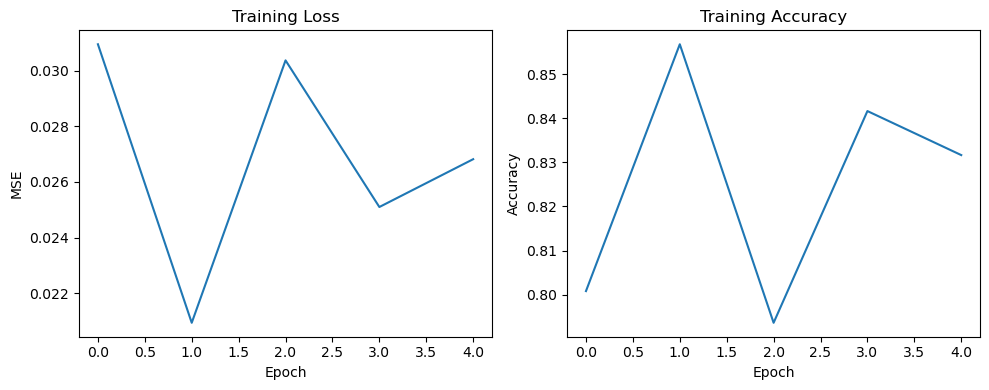

In [19]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")

plt.subplot(1,2,2)
plt.plot(history.history["color_accuracy"])
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

The training curves show a decreasing loss and increasing accuracy across epochs,
indicating that the model is learning meaningful color representations from grayscale
inputs.